In [1]:
import torch
from torch import nn
from torchvision.transforms import v2

import numpy as np
import pandas as pd

from PIL import Image

import pathlib as pl
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFolD

import matplotlib.pyplot as plt

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        
        labels = self.labels[idx]
        return image, labels

class RahmanDataset:
    def __init__(self, path, train_size=0.8, transform=None):
        self.path = path
        self.train_size = train_size
        self.transform = transform if transform is not None else v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
        self.labels_names = {0: 'noncarcinoma', 1: 'carcinoma'}
        self.train, self.test = self._train_test_split()

        self.train_dataset = CustomDataset(self.train[0], self.train[1], transform=self.transform)
        self.test_dataset = CustomDataset(self.test[0], self.test[1], transform=self.transform)
    
    def _get_files(self):
        """
        Get files from the path by class carcinoma and non-carcinoma
        """
        # carcinoma images
        carcinoma = list(self.path.glob("First Set/100x OSCC Histopathological Images/*.jpg"))
        carcinoma.extend(list(self.path.glob('Second Set/400x OSCC Histopathological Images/*.jpg')))
        
        # non-carcinoma images
        noncarcinoma = list(self.path.glob('First Set/100x Normal Oral Cavity Histopathological Images/*.jpg'))
        noncarcinoma.extend(list(self.path.glob('Second Set/400x Normal Oral Cavity Histopathological Images/*.jpg')))

        return carcinoma, noncarcinoma

    def _train_test_split(self):
        """
        Split the dataset into train and test
        """
        # get file complete path for each image file 
        carcinoma, noncarcinoma = self._get_files()

        # create arrays of 1 and 0 for carcinoma and non-carcinoma
        carcinoma_labels = list(np.ones(len(carcinoma)))
        noncarcinoma_labels = list(np.zeros(len(noncarcinoma)))

        # extend the labels
        labels = carcinoma_labels + noncarcinoma_labels
        images = carcinoma + noncarcinoma

        # split the dataset by parent name
        images_train, images_test, labels_train, labels_test = train_test_split(images, labels, train_size=self.train_size, stratify=labels, random_state=42)

        return (images_train, labels_train), (images_test, labels_test)


    def __len__(self):
        return len(self.train[0]) + len(self.test[0])

In [3]:
RAHMAN_PATH = pl.Path(os.path.abspath("")) / pl.Path('../data') / pl.Path('Histopathological imaging database for Oral Cancer analysis')
#Uncomment this to check if the root folder exists
# print(RAHMAN_PATH.exists())
print(f'RAHMAN_PATH.exists(): {RAHMAN_PATH.exists()}')

rahman_dataset = RahmanDataset(RAHMAN_PATH) 


RAHMAN_PATH.exists(): True


In [4]:
np.unique(rahman_dataset.test[1], return_counts=True)


(array([0., 1.]), array([ 58, 187]))

In [5]:
np.unique(rahman_dataset.train[1], return_counts=True)

(array([0., 1.]), array([232, 747]))

In [6]:
train_images = set(rahman_dataset.train[0])
test_images = set(rahman_dataset.test[0])

In [7]:
len(train_images.intersection(test_images))


0

In [8]:
len(rahman_dataset)

1224

In [9]:
len(rahman_dataset.train[0])

979

In [10]:
len(rahman_dataset.test[0])

245

In [11]:
train_images = set(rahman_dataset.train[0])
test_images = set(rahman_dataset.test[0])

In [12]:
len(train_images.intersection(test_images))

0

In [13]:
train_images.intersection(test_images)

set()

In [14]:
len(train_images)

979

In [15]:
len(test_images)

245

In [16]:
rahman_dataset.train_dataset[0]

(Image([[[0.8902, 0.8784, 0.8784,  ..., 0.8392, 0.7922, 0.7765],
         [0.9098, 0.8941, 0.8902,  ..., 0.8275, 0.8275, 0.8235],
         [0.9216, 0.9137, 0.8941,  ..., 0.8275, 0.8588, 0.8627],
         ...,
         [0.3686, 0.3843, 0.4118,  ..., 0.3569, 0.3961, 0.4078],
         [0.3765, 0.3725, 0.3882,  ..., 0.3569, 0.4078, 0.4235],
         [0.3294, 0.3490, 0.3882,  ..., 0.3608, 0.4118, 0.4314]],
 
        [[0.8902, 0.8902, 0.8902,  ..., 0.8667, 0.8431, 0.8392],
         [0.9098, 0.9059, 0.9020,  ..., 0.8549, 0.8627, 0.8706],
         [0.9294, 0.9216, 0.9059,  ..., 0.8510, 0.8706, 0.8706],
         ...,
         [0.3529, 0.3686, 0.4000,  ..., 0.3059, 0.3098, 0.3059],
         [0.3333, 0.3373, 0.3608,  ..., 0.2941, 0.2980, 0.2941],
         [0.2784, 0.3059, 0.3490,  ..., 0.2902, 0.2941, 0.2824]],
 
        [[0.7804, 0.7686, 0.7686,  ..., 0.7059, 0.6627, 0.6471],
         [0.8078, 0.8000, 0.7804,  ..., 0.6941, 0.6863, 0.6824],
         [0.8471, 0.8353, 0.8000,  ..., 0.7020, 0.7020, 

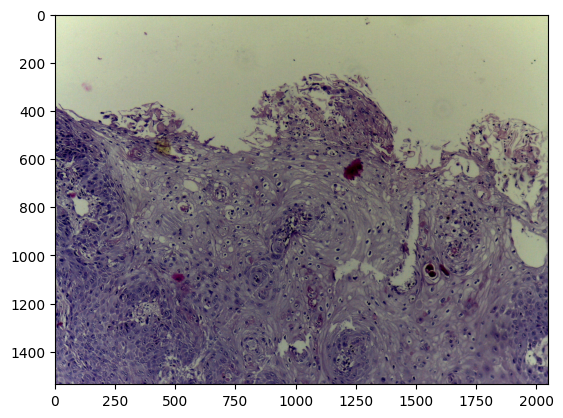

In [17]:
plt.imshow(rahman_dataset.train_dataset[0][0].permute(1, 2, 0))